In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import albumentations as A
import models
import dataloaders
import json
from train import get_instance
from utils.metrics import evaluate_dataloader
from utils.helpers import plot_inference

In [3]:
config_path = '../configs/unet_focal.json'
model_path = '/mnt/1058CF1419A58A26/saved/UNet/11-24_12-17/best_model.pth'

In [4]:
config = json.load(open(config_path))
print(config)

dataloader_val = get_instance(dataloaders, 'val_loader', config)
dataloader_test = get_instance(dataloaders, 'test_loader', config)

{'name': 'UNet', 'n_gpu': 1, 'use_synch_bn': False, 'arch': {'type': 'UNet', 'args': {'backbone': '', 'freeze_bn': False, 'freeze_backbone': False}}, 'train_loader': {'type': 'Bonn2016', 'args': {'data_dir': '/home/gustavu92/Desktop/trabalho-MO434/data/', 'batch_size': 4, 'base_size': 512, 'augment': True, 'shuffle': False, 'scale': False, 'flip': False, 'rotate': False, 'blur': False, 'split': 'train', 'num_workers': 4}}, 'val_loader': {'type': 'Bonn2016', 'args': {'data_dir': '/home/gustavu92/Desktop/trabalho-MO434/data/', 'batch_size': 4, 'base_size': 512, 'augment': True, 'shuffle': False, 'scale': False, 'flip': False, 'rotate': False, 'blur': False, 'val': True, 'split': 'val', 'num_workers': 4}}, 'test_loader': {'type': 'Bonn2016', 'args': {'data_dir': '/home/gustavu92/Desktop/trabalho-MO434/data/', 'batch_size': 4, 'base_size': 512, 'augment': True, 'shuffle': False, 'scale': False, 'flip': False, 'rotate': False, 'blur': False, 'val': True, 'split': 'test', 'num_workers': 4}},

In [5]:
loader = getattr(dataloaders, config['train_loader']['type'])(**config['train_loader']['args'])
num_classes = loader.dataset.num_classes

# Model
model = getattr(models, config['arch']['type'])(num_classes, **config['arch']['args'])
availble_gpus = list(range(torch.cuda.device_count()))
device = torch.device('cuda:0' if len(availble_gpus) > 0 else 'cpu')

checkpoint = torch.load(model_path)
if isinstance(checkpoint, dict) and 'state_dict' in checkpoint.keys():
    checkpoint = checkpoint['state_dict']
if 'module' in list(checkpoint.keys())[0] and not isinstance(model, torch.nn.DataParallel):
    model = torch.nn.DataParallel(model)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

{'root': '/home/gustavu92/Desktop/trabalho-MO434/data/', 'split': 'train', 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'augment': True, 'crop_size': None, 'base_size': 512, 'scale': False, 'flip': False, 'blur': False, 'rotate': False, 'return_id': False, 'val': False}


DataParallel(
  (module): UNet(
    (down1): encoder(
      (down_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (down2): encoder(
      (down_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

(Soil) Accuracy: 0.991, Precision: 0.996, Recall: 0.994, F1: 0.995
(Crop) Accuracy: 0.992, Precision: 0.817, Recall: 0.759, F1: 0.752
(Weed) Accuracy: 0.997, Precision: 0.112, Recall: 0.001, F1: 0.002
FPS: 18


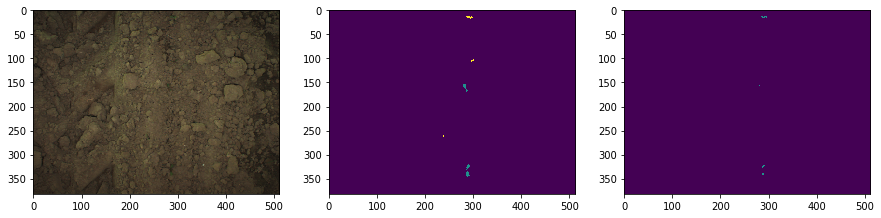

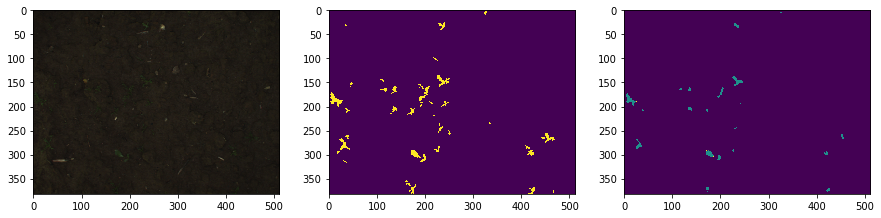

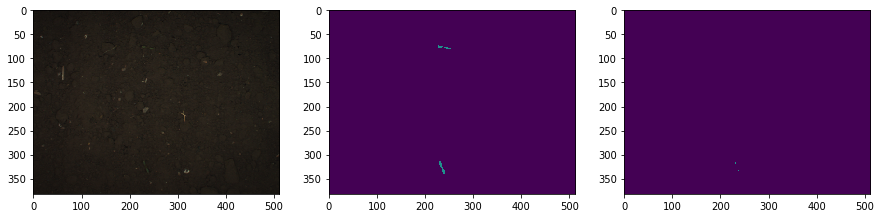

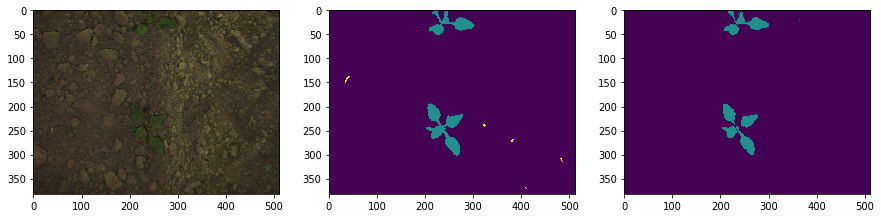

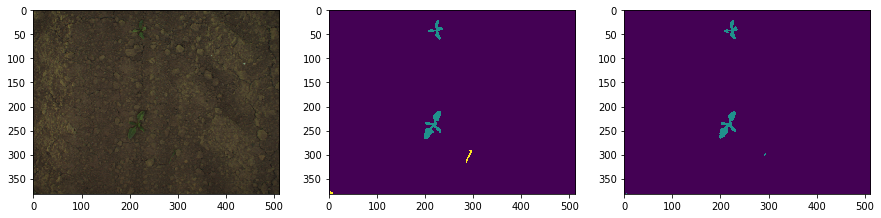

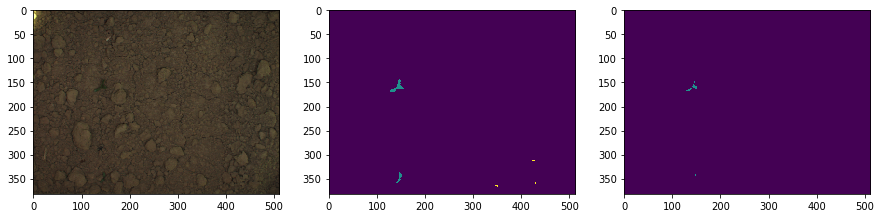

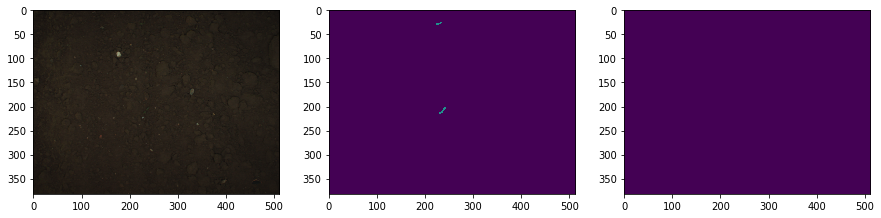

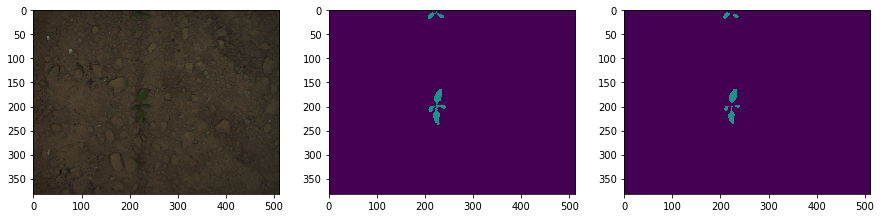

In [6]:
evaluate_dataloader(model, dataloader_val)
plot_inference(model, dataloader_val, batches=1)

(Soil) Accuracy: 0.992, Precision: 0.996, Recall: 0.995, F1: 0.996
(Crop) Accuracy: 0.992, Precision: 0.807, Recall: 0.745, F1: 0.737
(Weed) Accuracy: 0.996, Precision: 0.121, Recall: 0.001, F1: 0.002
FPS: 23


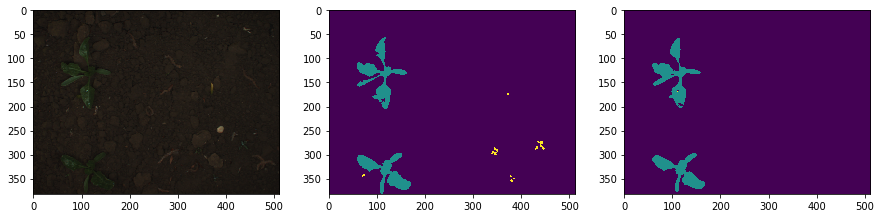

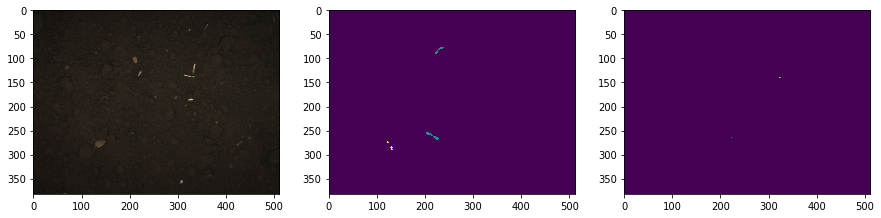

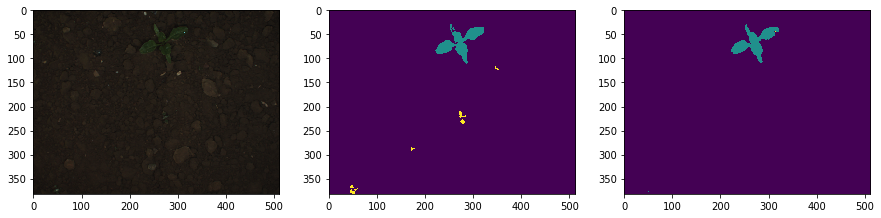

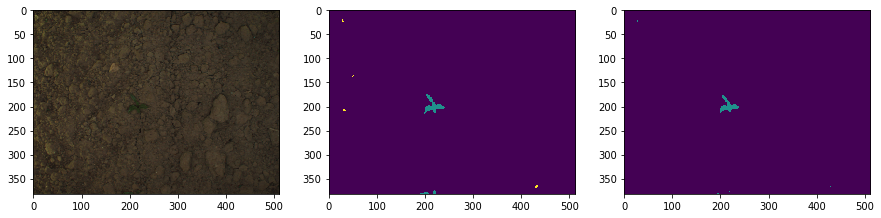

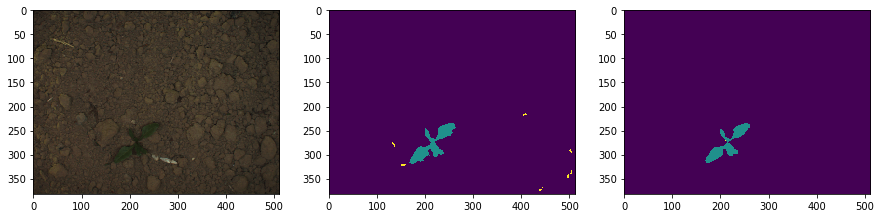

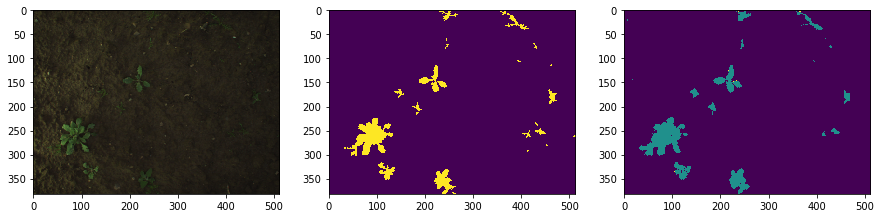

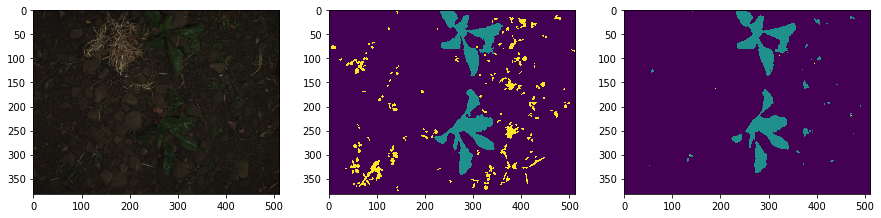

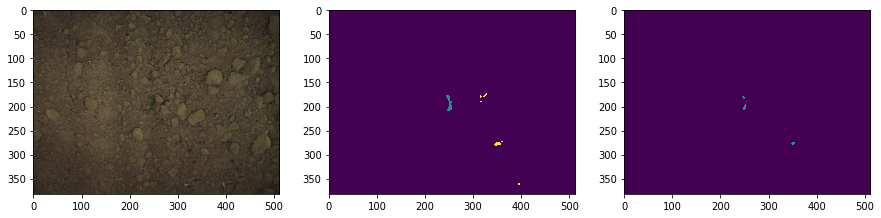

In [7]:
evaluate_dataloader(model, dataloader_test)
plot_inference(model, dataloader_test, batches=1)